<a href="https://colab.research.google.com/github/henrygas/unsupervised_learning/blob/master/K_Means_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 装载Google云盘

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. 切换当前工作目录

In [0]:
import os
os.chdir("./drive/My Drive/app/K-means-homework")

In [5]:
!ls

data  out


## 3. 读取数据，查看数据内容

In [6]:
import pandas as pd

data_path = "./data/training.csv"
data = pd.read_csv(data_path, names=["target", "intro"])
data.head()

,target,intro
0,2,合晟资产是一家专注于股票、债券等二级市场投资，为合格投资者提供专业资产管理服务的企业。公司业...
1,2,公司的主营业务为向中小微企业、个体工商户、农户等客户提供贷款服务，自设立以来主营业务未发生过变化。
2,1,公司立足于商业地产服务，致力于为商业地产开发、销售、运营全产业链提供一整套增值服务，业务覆盖...
3,2,公司经工商管理部门核准的经营范围为“投资咨询、经济信息咨询，企业管理咨询，品牌推广策划，公共...
4,2,该公司的主营业务为在中国境内(港、澳、台除外)开展保险代理销售，依托于自身的产品研究能力和专...


In [92]:
data.shape

(4774, 2)

## 4. 抽取文本特征

### 4.1 利用jieba分词组件对文本进行分词，并对分词结果去除停用词

In [0]:
import jieba
import chardet

stopwords_file = "./data/stopwords.txt"
jieba_result_file = "./out/jieba_result.txt"

stop_words = set()
with open(stopwords_file, encoding="gbk") as fr:
  stop_words = set([line.strip() for line in fr.readlines()])

with open(jieba_result_file, "w") as fw:
  for intro in data["intro"].values:
    fw.write("/".join(filter(lambda x : x not in stop_words, jieba.cut(intro))))
    fw.write("\n")


### 4.2 采用词袋和TF-IDF相结合，抽取文本特征

TF-IDF的作用是找出某些词用以提取该词所在文档的特色，而词袋模型的作用是找出文档中出现频率高的词；

而有特色的词，既有可能是有意义的专业词，又有可能是无意义的生僻词，可以考虑将两者结合起来，具体步骤是:

+ 通过词袋模型挑出一堆热词;
+ 再用TF-IDF对这些热词加权，得到有区分度的词。


这样就可以通过控制热词数，来将无意义的常用词和有意义的专业词都框进来；

然后再通过加权技术，排除掉无意义的常用词，争取留下有意义的专业词。

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

with open(jieba_result_file, "r") as fr:
  content = np.array([line.strip() for line in fr.readlines()])

tfidf_vec = TfidfVectorizer(min_df=5, max_df=60, token_pattern=r"(?u)\b\w\w+\b")
X_tfidf = tfidf_vec.fit_transform(content)

list(tfidf_vec.vocabulary_.items())[:10]

[('股票', 4222),
 ('债券', 1015),
 ('二级', 715),
 ('合格', 1650),
 ('投资者', 2615),
 ('顾问', 5001),
 ('私募', 3827),
 ('基金', 1867),
 ('证券', 4466),
 ('总资产', 2480)]

In [94]:
X_tfidf.shape

(4774, 5147)

## 5. 对文本特征进行K-means聚类分析

### 5.1 选择轮廓系数作为评价指标，分别计算聚类数K=5,10,15,...,50时的轮廓系数均值，画出轮廓系数均值随K变化的曲线。

In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import time
from functools import wraps

def log(name=None):
  def _wrapper(func):
    @wraps(func)
    def _log(*args, **xargs):
      time_start = time.time()
      print("starting to {}".format(name))
      rtn = func(*args, **xargs)
      print("end to {}, cost time {:.4f}秒".format(name, time.time() - time_start))

      return rtn

    return _log
  
  return _wrapper

@log(name="kmeans")
def kmeans(n_clusters, input):
  estimator = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, precompute_distances="auto")
  y = estimator.fit_predict(input)

  return y, estimator

@log(name="get_silhouette_score")
def get_silhouette_score(input, y):
  return silhouette_score(input, y, metric="euclidean")

estimators = list()
for k in range(5, 55, 20):
  print("\ntrying k={}".format(k))
  y, estimator = kmeans(k, X_tfidf)

  each_sse_score = estimator.inertia_
  each_silhouette_score = get_silhouette_score(X_tfidf, y)
  estimators.append([estimator, each_sse_score, each_silhouette_score, y])

print("Over!")


trying k=5
starting to kmeans
end to kmeans, cost time 37.2731秒
starting to get_silhouette_score
end to get_silhouette_score, cost time 0.3659秒

trying k=25
starting to kmeans
end to kmeans, cost time 39.1635秒
starting to get_silhouette_score
end to get_silhouette_score, cost time 0.3306秒

trying k=45
starting to kmeans
end to kmeans, cost time 23.2200秒
starting to get_silhouette_score
end to get_silhouette_score, cost time 0.3857秒
Over!


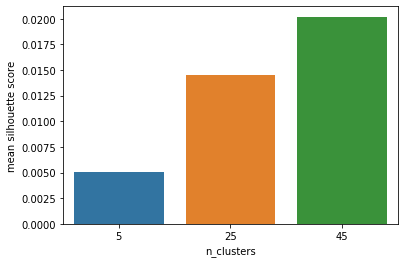

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

x_range = list(range(5, 55, 20))
y_range = np.array(estimators)[:, 2]

sns.barplot(x=x_range, y=y_range)
plt.xlabel("n_clusters")
plt.ylabel("mean silhouette score")
plt.show()

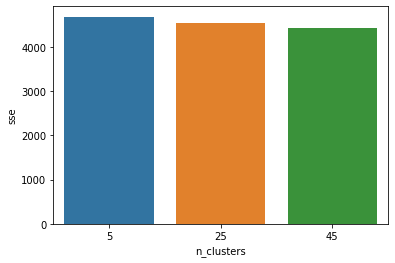

In [97]:
y_range = np.array(estimators)[:, 1]

sns.barplot(x=x_range, y=y_range)
plt.xlabel("n_clusters")
plt.ylabel("sse")
plt.show()

在30,35,45,50之间，选择聚类结果的各类别轮廓系数方差最小的那一个

In [38]:
score_array_ordered = np.sort(score_array, axis=1).
print(score_array_ordered)

[[8.28148227e-03 5.00000000e+00]
 [1.11584371e-02 1.00000000e+01]
 [1.17821433e-02 1.50000000e+01]
 [1.19037323e-02 2.00000000e+01]
 [1.13194098e-02 2.50000000e+01]
 [1.30793489e-02 3.00000000e+01]
 [1.38934461e-02 3.50000000e+01]
 [1.28545252e-02 4.00000000e+01]
 [1.44482656e-02 4.50000000e+01]
 [1.51961546e-02 5.00000000e+01]]


### 5.2 选择CH索引作为评价指标，分别计算聚类数K=5,10,15,...,50时的CH索引均值，画出CH索引均值随K变化的曲线。